# 1. SETUP

## 1.1 Dependencies


In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.2 GPU Setup

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. COLLECTING DATA

In [ ]:
# Setting random seeds to enable consistency while testing.
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "./nice-dataset/"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = image.astype(np.uint8)  # Convert the data type to np.uint8
    return image

## 2.1 COLLECT AND SPLIT DATASET

In [ ]:
random.seed(1144)

def generate_prediction_data_v1(file_path):
    test_input = [] 
    test_val = []
    y_true = []
    k=1
    positive_counter = 0
    negative_counter = 0
    xdd = random.randint(0,1)
    folder_list = os.listdir(file_path)
    print(len(folder_list))
    for folder in folder_list: 
        print("ITER no:",k,"folder name:",folder)
        k+=1
        #Get random image for val
        image_list = os.listdir(os.path.join(file_path,folder))
        anchor_path = os.path.join(file_path,folder,image_list[0])
        negative_tuple_count = len(image_list)
        #Generate positive test case
        for i in range(1,len(image_list)):
            positive_counter+=1
            positive_path = os.path.join(file_path,folder,image_list[i])
            test_input.append(positive_path)
            test_val.append(anchor_path)
            y_true.append(1)

        #Generating negative test-case
        neg_folder = folder
        while neg_folder == folder:
            neg_folder = random.choice(folder_list)    
        neg_files = os.listdir(os.path.join(file_path, neg_folder))   

        if(len(image_list) == 1):
            
            negative_path = os.path.join(file_path,neg_folder, neg_files[0])

            test_input.append(negative_path)
            test_val.append(anchor_path)
            y_true.append(0)
            continue
        
        negative_tuple_count = min(negative_tuple_count,len(neg_files)) 
        for j in range(negative_tuple_count):
            negative_counter+=1
            negative_path = os.path.join(file_path,neg_folder, neg_files[j])
            test_input.append(negative_path)
            test_val.append(anchor_path)
            y_true.append(0)

        
    
    print(f"END OF CREATING TEST... \n Positive count: {positive_counter} \n Negative count: {negative_counter}")
    # for i in range(len(test_input)):
    #     print("Input:",test_input[i],"Validation: ",test_val[i],"Label:",y_true[i])
    test_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(test_input), 
                                        tf.data.Dataset.from_tensor_slices(test_val), 
                                        tf.data.Dataset.from_tensor_slices(y_true) ))
    return test_dataset



### VERSION 2

In [ ]:
def generate_negative_case(file_path,folder,anchor_img_path):
    
    folder_list = os.listdir(file_path)

    neg_folder = folder
    while neg_folder == folder:
        neg_folder = random.choice(folder_list)
    
    neg_files = os.listdir(os.path.join(file_path, neg_folder))       
    negative = os.path.join(file_path,neg_folder, random.choice(neg_files))
    y = 0

    return (negative,anchor_img_path,y)

          

In [ ]:
def generate_positive_case(file_path,folder,anchor_img_path):
    positive = anchor_img_path
    image_list = os.listdir(os.path.join(file_path,folder))
    
    while positive == anchor_img_path:
        positive = random.choice(image_list)

    positive = os.path.join(file_path,folder,positive)
    y = 1

    return (positive,anchor_img_path,y) 

        

## 2.2 CATEGORIZE (ANCHOR, POSITIVE, NEGATIVE) IMAGES

In [ ]:
# partition_1 = generate_prediction_data_v1('./face-dataset-cropped')
# partition_2 = generate_prediction_data_v1('./nice-dataset/')
# data = partition_1.concatenate(partition_2)

In [ ]:
data = generate_prediction_data_v1('./face-dataset-cropped/')

In [ ]:
print("Len data: ",len(data))

# 3. Preprocessing

In [ ]:
def preprocess_png(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_png(byte_img, channels=3)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (128,128))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [ ]:
def preprocess_jpg(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img, channels=3)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (128,128))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess_jpg(input_img), preprocess_jpg(validation_img), label)

In [ ]:
data = data.map(preprocess_twin)
data.cache()

## Splitting

In [ ]:
train_data = data.take(round(len(data)))
train_data = train_data.batch(batch_size=64)
train_data = train_data.prefetch(buffer_size= tf.data.AUTOTUNE)

# 4. MODEL BUILDING

### 4.0 TESTING ZONE

In [ ]:
# I just want to make sure everything is alright

### 4.1. Embedding layer

In [ ]:
def make_embedding(): 
    inp = Input(shape=(128,128,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()
embedding.summary()

### 4.2. Build Distance Layer

In [ ]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
# class L2Dist(Layer):
#     # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     def call(self, input_embedding, validation_embedding):
#         return tf.reduce_sum(tf.square(input_embedding - validation_embedding), -1)

In [ ]:
l1 = L1Dist()

In [ ]:
# l1(anchor_embedding, validation_embedding)

### 4.2.3 Make Siamese model

In [ ]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(128,128,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(128,128,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

# 5. TRAINING MODELS

## 5.1 SIAMESE

### 5.1.1 Setup Loss and Optimizer

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.1.2 Checkpoints

In [ ]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
# checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.1.3 Train Step Function

In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
X = batch_1[:2]

In [ ]:
y = batch_1[2]

In [ ]:
# just for testing
y

In [ ]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
          
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### 5.1.4 Train loop

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def train(data, EPOCHS):
    # Initialize lists to store loss and accuracy values
    losses = []
    recall = []
    precision = []
    # Creating a metric object 
    # r = Recall()
    # p = Precision()
    
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
       

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            
            # Calculate accuracy
            # yhat = siamese_model.predict(batch[:2])
            # r.update_state(batch[2], yhat)
            # p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(f"Loss: {loss.numpy()}")
        # Save checkpoints
        # if epoch % 10 == 0: 
            # checkpoint.save(file_prefix=checkpoint_prefix)

        # Calculate and print average loss and accuracy for the e==============poch
        

        # Append loss and accuracy to lists
        losses.append(loss.numpy())
        # recall.append(r.result().numpy())
        # precision.append(p.result().numpy())

    # Plot loss 
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    


In [ ]:
def train2(data, loss_threshold):
    # Initialize lists to store loss and accuracy values
    losses = []
    # Creating a metric object 
    # r = Recall()
    # p = Precision()

    epoch = 1
    print('\n Epoch {}'.format(epoch))
    progbar = tf.keras.utils.Progbar(len(data))
    for idx, batch in enumerate(data):
            loss = train_step(batch)
            
            # Calculate accuracy
            # yhat = siamese_model.predict(batch[:2])
            # r.update_state(batch[2], yhat)
            # p.update_state(batch[2], yhat) 
            progbar.update(idx+1)

    print(f"Loss: {loss.numpy()}")

    while loss > loss_threshold:
        print('\n Epoch {}'.format(epoch))
        progbar = tf.keras.utils.Progbar(len(data))
        epoch +=1

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            
            # Calculate accuracy
            # yhat = siamese_model.predict(batch[:2])
            # r.update_state(batch[2], yhat)
            # p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(f"Loss: {loss.numpy()}")
        # Save checkpoints
        # if epoch % 10 == 0: 
            # checkpoint.save(file_prefix=checkpoint_prefix)

        # Calculate and print average loss and accuracy for the e==============poch
        

        # Append loss and accuracy to lists
        losses.append(loss.numpy())
        # recall.append(r.result().numpy())
        # precision.append(p.result().numpy())

    # Plot loss 
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    


### 5.1.5 Training time

In [ ]:
EPOCHS = 35 # modifiable

In [ ]:
train2(train_data, 0.13)

# 6. EVALUATION

In [ ]:
remove = [1,
 2,
 3,
 7,
 15,
 17,
 18,
 19,
 20,
 22,
 24,
 27,
 37,
 38,
 39,
 40,
 43,
 47,
 50,
 51,
 58,
 67,
 70,
 71,
 72,
 73,
 74,
 75,
 80,
 82,
 88,
 90,
 91,
 96,
 97,
 101]

# Make a test dataset

In [ ]:
# Structure of file path should be a folder with subfolders, each subfolders contain images of a subject.
def generate_test_data(seed_num:int,file_path):

    random.seed(seed_num)
    
    test_input = [] 
    test_val = []
    y_true = []
    cnt = 0
    #counters
    positive_counter = 0
    negative_counter = 0

    folder_list = os.listdir(file_path)

    print(len(folder_list))
    for folder in folder_list: 
        
        #Get image list
        image_list = os.listdir(os.path.join(file_path,folder))       

        #Creating positive case
        for anchor_image in image_list:
            img_idx = image_list.index(anchor_image)
            anchor_path = os.path.join(file_path,folder,anchor_image)

            for i in range(img_idx+1,len(image_list)):             
                positive_counter+=1

                positive_path = os.path.join(file_path,folder,image_list[i])      

                test_input.append(positive_path)
                test_val.append(anchor_path) 
                y_true.append(1)

        #Creating negative case
        anchor_path = os.path.join(file_path,folder,random.choice(image_list))
        
        neg_folder = folder
        while neg_folder == folder:
            neg_folder = random.choice(folder_list)        
        
        neg_files = os.listdir(os.path.join(file_path, neg_folder))   

        for negative_image in neg_files:
            negative_counter+=1

            negative_path = os.path.join(file_path,neg_folder, negative_image)

            test_input.append(negative_path)
            test_val.append(anchor_path)
            y_true.append(0)

    #DARK MAGIC   
    test_input_real = [] 
    test_val_real = []
    y_true_real = []    
    for i in range(len(test_input)):
        if (i in remove) and (cnt<len(remove)/2):      
            cnt+=1
            continue
        test_input_real.append(test_input[i])
        test_val_real.append(test_val[i])
        y_true_real.append(y_true[i])

    print(f"END OF CREATING TEST... \n Positive count: {positive_counter} \n Negative count: {negative_counter}")
    for i in range(len(test_input_real)):
        print("Iter no:",i,"Input:",test_input_real[i],"Validation: ",test_val_real[i],"Label:",y_true_real[i])
    test_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(test_input_real), 
                                        tf.data.Dataset.from_tensor_slices(test_val_real), 
                                        tf.data.Dataset.from_tensor_slices(y_true_real) ))
    return test_dataset

In [ ]:
test_data = generate_test_data(file_path='./verif-dataset-cropped',seed_num=269)

In [ ]:


def verify(valid_path, input_img_a, detection_threshold, verification_threshold):
    results = []
    input_img = preprocess_png(input_img_a)
    validation_img = preprocess_png(valid_path)

    plt.subplot(1,2,1)
    plt.imshow(input_img)

    plt.subplot(1,2,2)
    plt.imshow(validation_img )
    # Make Predictions 
    result = siamese_model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection 
    verified = verification > verification_threshold

    print(verified)
    print(results)
    
    return str(verified)

1/1 [==============================] - 0s 19ms/step
True
[array([[0.99966455]], dtype=float32)]


'True'

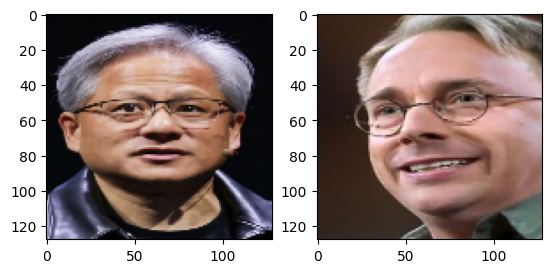

In [66]:
verify('./verif-dataset-cropped/linus/linus3.png','./verif-dataset-cropped/jensen/jensen4.png',0.65,0.5)

## 6.2 Make Predictions

## 6.3 CALCULATE METRICS

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
def verify_set(test_img,validation_img, detection_threshold=0.5):
    results = []
    input_img = preprocess_png(test_img)
    validation_img = preprocess_png(validation_img)

    # Make Predictions 
    result = siamese_model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    return (detection)

In [45]:
predicted = np.array([])
true_label = np.array([])
cnt = 0
for i in test_data.as_numpy_iterator():
    a, t, l = i 
    predicted =  np.append(predicted, verify_set(a,t,0.65))
    true_label = np.append(true_label,l)


1/1 [==============================] - 0s 13ms/step



Accuracy of model: 0.7857142857142857

PRECISION: 0.8571428571428571
RECALL: 0.7924528301886793
F1 SCORE: 0.8235294117647058
Positive count:  0 Negative count: 0
[24, 7, 11, 42]
<class 'numpy.int64'>


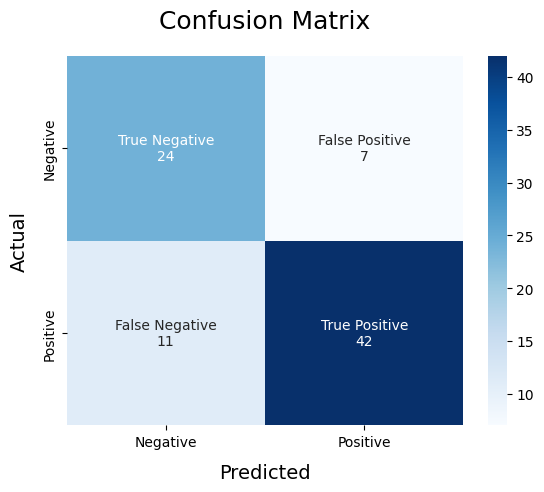

In [46]:
def ModelMetrics(pred,true):
    negative_count = 0
    positive_count = 0
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Negative','Positive']
    names = ['True Negative','False Positive', 'False Negative','True Positive']
    percentages = [value for value in cf_matrix.flatten() ]

    #FOR METRICS
    precision = float(percentages[3]/(percentages[3]+percentages[1]))
    print("PRECISION:",precision)
    recall = float(percentages[3]/(percentages[3]+percentages[2]))
    print("RECALL:",recall)
    f1 = 2*(precision*recall)/(precision+recall)
    print("F1 SCORE:",f1)

    print("Positive count: ", positive_count, "Negative count:",negative_count)
    print(percentages)
    print(type(percentages[0]))
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
ModelMetrics(predicted,true_label)

## ROC CURVE

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

THRESHOLD: 0.0
1/1 [==============================] - 0s 15ms/step
[0, 31, 0, 53]
THRESHOLD: 0.01
1/1 [==============================] - 0s 13ms/step
[2, 29, 0, 53]
THRESHOLD: 0.02
1/1 [==============================] - 0s 14ms/step
[3, 28, 0, 53]
THRESHOLD: 0.03
1/1 [==============================] - 0s 11ms/step
[4, 27, 0, 53]
THRESHOLD: 0.04
1/1 [==============================] - 0s 12ms/step
[4, 27, 0, 53]
THRESHOLD: 0.05
1/1 [==============================] - 0s 13ms/step
[5, 26, 0, 53]
THRESHOLD: 0.060000000000000005
1/1 [==============================] - 0s 16ms/step
[5, 26, 0, 53]
THRESHOLD: 0.07
1/1 [==============================] - 0s 12ms/step
[5, 26, 0, 53]
THRESHOLD: 0.08
1/1 [==============================] - 0s 13ms/step
[5, 26, 0, 53]
THRESHOLD: 0.09
1/1 [==============================] - 0s 13ms/step
[5, 26, 0, 53]
THRESHOLD: 0.09999999999999999
1/1 [==============================] - 0s 14ms/step
[6, 25, 0, 53]
THRESHOLD: 0.10999999999999999
1/1 [=====================

Text(0.5, 1.0, 'ROC (FAR–FRR–ERR) curves')

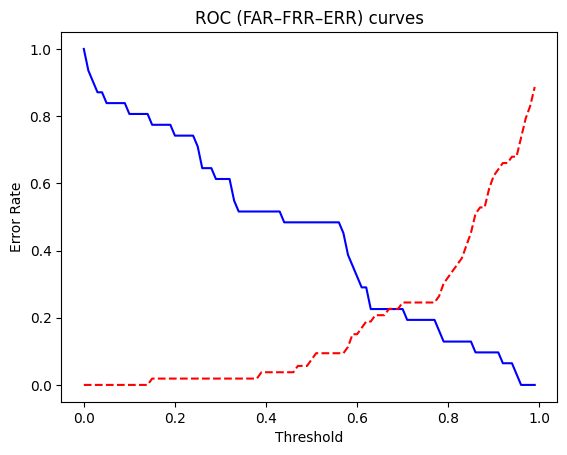

In [27]:
threshold = 0. 
step = .01
FRR_x = []
FRR_y = []
FAR_x = []
FAR_y = []
while threshold <=1.:
    print("THRESHOLD:",threshold)
    predicted = np.array([])
    true_label = np.array([])
    for i in test_data.as_numpy_iterator():
        a, t, l = i 
        predicted =  np.append(predicted, verify_set(a,t,threshold))
        true_label = np.append(true_label,l)
   
    cf_matrix = confusion_matrix(true_label, predicted)
    #CONVERT TO FLoAT FOR easier calculations
    percentages = [value for value in cf_matrix.flatten() ] #FORMAT : ['True Negative','False Positive', 'False Negative','True Positive']
    
    print(percentages)
    FRR_y.append(  float(percentages[2] / ( percentages[3] + percentages[2] ))   )
    FAR_y.append( float(percentages[1] / ( percentages[1] + percentages[0] )) )
    #X-axis values
    FRR_x.append(threshold)
    FAR_x.append(threshold)
    threshold+=step

print(FRR_y)
print(FAR_y)
plt.plot(FAR_x, FAR_y, linestyle='-', color='b', label='Graph 1')
# Plotting the second set of points
plt.plot(FRR_x, FRR_y, linestyle='--', color='r', label='Graph 2')
# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('ROC (FAR–FRR–EER) curves')

## ROC AND AUC

In [39]:
predicted = np.array([])
true_label = np.array([])
for i in test_data.as_numpy_iterator():
    a, t, l = i 
    predicted =  np.append(predicted, verify_set(a,t,1.))
    true_label = np.append(true_label,l)

cf_matrix = confusion_matrix(true_label, predicted)
#CONVERT TO FLoAT FOR easier calculations
percentages = [value for value in cf_matrix.flatten() ] #FORMAT : ['True Negative','False Positive', 'False Negative','True Positive']

print(percentages)
FRR_y.append(  float(percentages[2] / ( percentages[3] + percentages[2] ))   )
FAR_y.append( float(percentages[1] / ( percentages[1] + percentages[0] )) )
#X-axis values
FRR_x.append(threshold)
FAR_x.append(threshold)

1/1 [==============================] - 0s 13ms/step
[31, 0, 53, 0]


Text(0.5, 1.0, 'ROC (FAR–FRR–EER) curves')

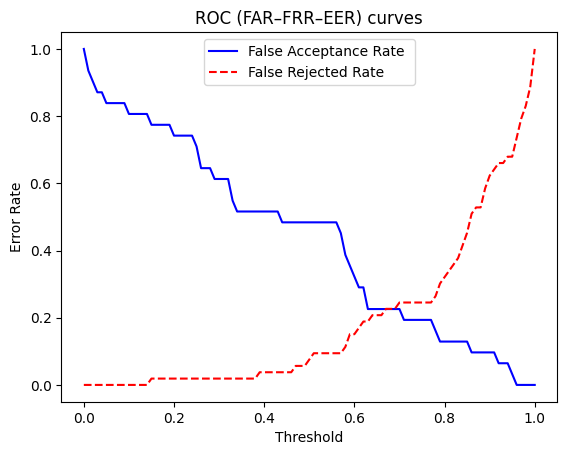

In [47]:
FAR =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.018867924528301886, 0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.05660377358490566, 0.05660377358490566, 0.05660377358490566, 0.07547169811320754, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.11320754716981132, 0.1509433962264151, 0.1509433962264151, 0.16981132075471697, 0.18867924528301888, 0.18867924528301888, 0.20754716981132076, 0.20754716981132076, 0.20754716981132076, 0.22641509433962265, 0.22641509433962265, 0.22641509433962265, 0.24528301886792453, 0.24528301886792453, 0.24528301886792453, 0.24528301886792453, 0.24528301886792453, 0.24528301886792453, 0.24528301886792453, 0.24528301886792453, 0.2641509433962264, 0.3018867924528302, 0.32075471698113206, 0.33962264150943394, 0.3584905660377358, 0.37735849056603776, 0.41509433962264153, 0.4528301886792453, 0.5094339622641509, 0.5283018867924528, 0.5283018867924528, 0.5849056603773585, 0.6226415094339622, 0.6415094339622641, 0.660377358490566, 0.660377358490566, 0.6792452830188679, 0.6792452830188679, 0.7358490566037735, 0.7924528301886793, 0.8301886792452831, 0.8867924528301887]
FRR =[1.0, 0.9354838709677419, 0.9032258064516129, 0.8709677419354839, 0.8709677419354839, 0.8387096774193549, 0.8387096774193549, 0.8387096774193549, 0.8387096774193549, 0.8387096774193549, 0.8064516129032258, 0.8064516129032258, 0.8064516129032258, 0.8064516129032258, 0.8064516129032258, 0.7741935483870968, 0.7741935483870968, 0.7741935483870968, 0.7741935483870968, 0.7741935483870968, 0.7419354838709677, 0.7419354838709677, 0.7419354838709677, 0.7419354838709677, 0.7419354838709677, 0.7096774193548387, 0.6451612903225806, 0.6451612903225806, 0.6451612903225806, 0.6129032258064516, 0.6129032258064516, 0.6129032258064516, 0.6129032258064516, 0.5483870967741935, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.5161290322580645, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.45161290322580644, 0.3870967741935484, 0.3548387096774194, 0.3225806451612903, 0.2903225806451613, 0.2903225806451613, 0.22580645161290322, 0.22580645161290322, 0.22580645161290322, 0.22580645161290322, 0.22580645161290322, 0.22580645161290322, 0.22580645161290322, 0.22580645161290322, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.1935483870967742, 0.16129032258064516, 0.12903225806451613, 0.12903225806451613, 0.12903225806451613, 0.12903225806451613, 0.12903225806451613, 0.12903225806451613, 0.12903225806451613, 0.0967741935483871, 0.0967741935483871, 0.0967741935483871, 0.0967741935483871, 0.0967741935483871, 0.0967741935483871, 0.06451612903225806, 0.06451612903225806, 0.06451612903225806, 0.03225806451612903, 0.0, 0.0, 0.0, 0.0]
plt.plot(FAR_x, FAR_y, linestyle='-', color='b', label='False Acceptance Rate ')
# Plotting the second set of points
plt.plot(FRR_x, FRR_y, linestyle='--', color='r', label='False Rejected Rate')
# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.legend()
plt.title('ROC (FAR–FRR–EER) curves')

In [41]:
# Take the list from plotting EER steps

# False rejected rate = False Negative / (False Negative + True Positive) = False Negative / Actually Positive 
# FRR = [0.0, 0.0, 0.018867924528301886, 0.018867924528301886, 0.03773584905660377, 0.07547169811320754, 0.1509433962264151, 0.24528301886792453, 0.32075471698113206, 0.6226415094339622, 1.0]
# # False accepted rate = False Positive / (False Positive + True Negative) = False Positive / Actually Negative
# FAR = [1.0, 0.8064516129032258, 0.7419354838709677, 0.6129032258064516, 0.5161290322580645, 0.4838709677419355, 0.3225806451612903, 0.22580645161290322, 0.12903225806451613, 0.0967741935483871, 0.0]

# => Need True positive and false positive rate?
# True positive rate = True Positive / (True Positive + False Negative) = True Positive / Actually Positive = 1 - FRR
TPR = []
for rate in FRR_y:
    new_rate = 1.0 - rate
    TPR.append(new_rate)
# False positive rate = False Positive / (False Positive + True Negative) = False Positive / Actually Negative = FAR
FPR = FAR_y

# TPR = y axis
# FPR = x axis

In [42]:
from sklearn.metrics import auc

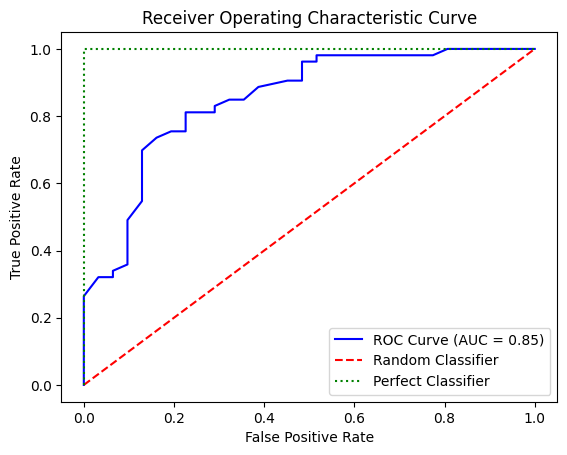

In [43]:
# Define the base line
base = [0.0, 1.0]

# Define the perfect line
perfect_x = [0.0, 0.0, 1.0]
perfect_y = [0.0, 1.0, 1.0]

# Calculate the AUC score for ROC curve
auc_score = auc(FPR, TPR)

# Plot the curve
plt.plot(FPR, TPR, 'b', label='ROC Curve (AUC = %0.2f)' % (auc_score))
plt.plot(base, base, linestyle='--', color='r', label='Random Classifier')
plt.plot(perfect_x, perfect_y, linestyle=':', color='g', label='Perfect Classifier')

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

# 7. Saving model

In [ ]:
stop

In [ ]:
def save_model(model,version:str, config:str):
    try:
        os.mkdir(version)
    except:
        print(f'Directory {version} already created!')

    with open(f'./{version}/{version}.txt', 'w') as fp:
        fp.writelines('Config of the model: ')
        fp.write(config)
    model.save(f'./{version}/{version}.h5')

In [ ]:

#Please change version name and config if you made changes to them during the building process
save_model(siamese_model, version='Siamese_v1_06',config= """
   def make_embedding(): 
    inp = Input(shape=(128,128,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
           
    class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
    epoch = 35
""")

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('./Siamese_v1_06/Siamese_v1_06.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})